In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import TraceModel as tm
import simple_solver as ss

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-029 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-031
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [386]:
import importlib
importlib.reload(ss)

<module 'simple_solver' from '/Users/michaelradica/Documents/GitHub/jwst-mtl/SOSS/extract/Trace_Profile/simple_solver.py'>

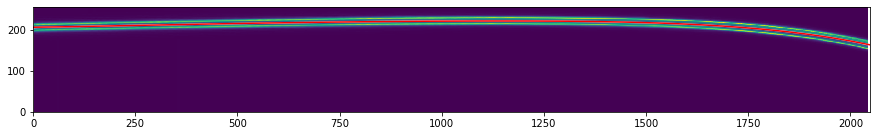

(0, 256)

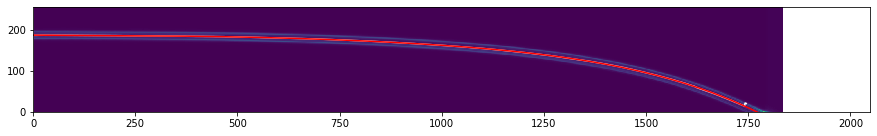

In [6]:
ref_O1 = fits.open('trace_profile_m1.fits')[0].data[::-1,:]
x, y = ss.get_uncontam_centroids(ref_O1, atthesex=np.arange(2048))
plt.figure(figsize=(15, 3))
plt.imshow(ref_O1/np.sum(ref_O1, axis=0), origin='lower')
plt.plot(x, y, c='white')
plt.plot(np.arange(2048), np.polyval(p1, np.arange(2048)), c='red')
plt.xlim(0,2048)
plt.ylim(0,256)
plt.show()

ref_O2 = fits.open('trace_profile_m2.fits')[0].data[::-1,:]   
x2, y2 = ss.get_uncontam_centroids(ref_O2, atthesex=np.arange(1750))
plt.figure(figsize=(15, 3))
plt.imshow(ref_O2/np.sum(ref_O2, axis=0), origin='lower')
plt.plot(x2,y2, c='white')
plt.plot(np.arange(2048), np.polyval(p2, np.arange(2048)), c='red')
plt.xlim(0,2048)
plt.ylim(0,256)

In [5]:
# Optics model centroids
xom1, yom1, tps = tm.get_om_centroids(atthesex=np.arange(2048), order=1)
xom2, yom2, tps = tm.get_om_centroids(atthesex=np.arange(2048), order=2)

# polyfits to reference traces
p1 = np.polyfit(x, y, 5)
p2 = np.polyfit(x2, y2, 5)

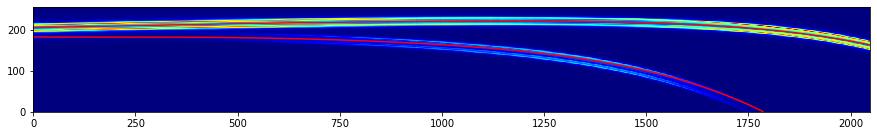

In [10]:
# Open simulated CLEAR exposure
clear = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/simu_F277_CLEAR/clear.fits')[0].data[::-1, :]

plt.figure(figsize=(15, 3))
plt.imshow(clear/np.sum(clear, axis=0), origin='lower', cmap='jet')
plt.plot(xc, yc, c='red')
plt.plot(xc2, yc2, c='red')

In [9]:
# Data centroids
xc, yc, xc2, yc2, rot_par = ss.get_contam_centroids(clear, return_rot_params=True)

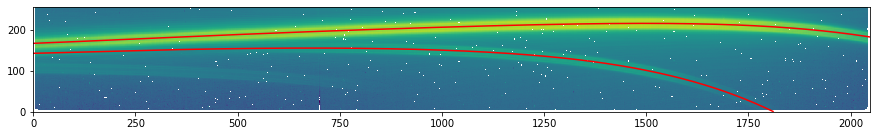

In [13]:
# Open a 'CLEAR' exposure from CV3.
stack = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Gaussian_model/InputFiles/CleanStack.fits')[0].data
stack[np.where(np.isnan(stack))] = 0

plt.figure(figsize=(15, 3))
plt.imshow(np.log10(stack), origin='lower')
plt.plot(xc, yc, c='red')
plt.plot(xc2, yc2, c='red')

In [12]:
# Data centroids
xc, yc, xc2, yc2, rot_par = ss.get_contam_centroids(stack, return_rot_params=True)

### Rotate the reference traces

In [23]:
rotframe_o1 = ss.simple_solver(xc, yc, order=1)

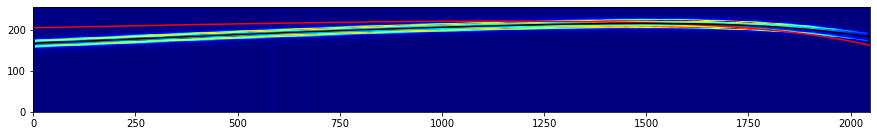

In [25]:
plt.figure(figsize=(15, 3))
plt.imshow(rotframe_o1, origin='lower', cmap='jet')
plt.plot(xom1, yom1, c='red')
plt.plot(xc, yc, c='black')

In [26]:
rotframe_o2 = ss.simple_solver(xc2, yc2, order=2)

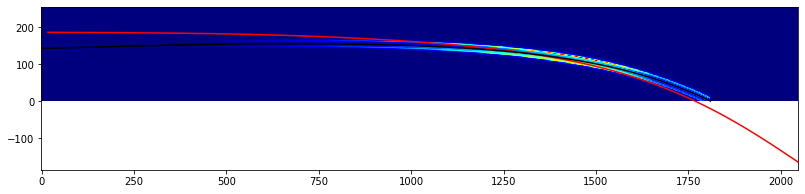

In [27]:
plt.figure(figsize=(15, 3))
plt.imshow(rotframe_o2, origin='lower', cmap='jet')
plt.plot(xom2, yom2, c='red')
plt.plot(xc2, yc2, c='black')

## Derive rotation from optics model to CV3 and link between orders 1 and 2

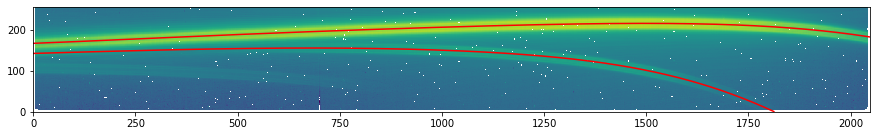

In [337]:
# Open a 'CLEAR' exposure from CV3.
stack = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Gaussian_model/InputFiles/CleanStack.fits')[0].data
stack[np.where(np.isnan(stack))] = 0

plt.figure(figsize=(15, 3))
plt.imshow(np.log10(stack), origin='lower')
plt.plot(xc, yc, c='red')
#plt.plot(xtest, ytest, c='black')
plt.plot(xc2, yc2, c='red')
#plt.plot(xtest2, ytest2, c='black')


In [335]:
import importlib
importlib.reload(tm)

<module 'TraceModel' from '/Users/michaelradica/Documents/GitHub/jwst-mtl/SOSS/extract/Trace_Profile/TraceModel.py'>

In [336]:
# data centroids
#xc, yc = ss.get_o1_data_centroids(stack, atthesex=np.arange(2048))
xc2, yc2, xc, yc = tm.get_o2_data_centroids(stack, return_o1=True)

In [169]:
pp = np.polyfit(xc2, yc2, 5)

In [102]:
mask = np.ones((256, 2048))
for xx, yy in zip(xc, yc):
    xxx = int(round(xx,0))
    yyy = int(round(yy,0))
    
    mask[(yyy-31):(yyy+30), xxx] = 0

In [192]:
test = stack * mask

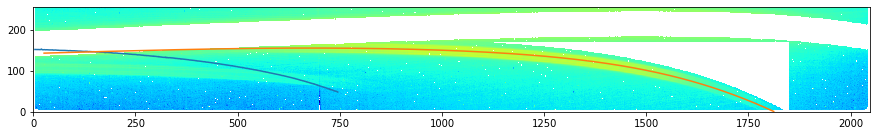

In [282]:
plt.figure(figsize=(15, 3))
#plt.imshow(test[0:170,950:1850], origin='lower', cmap='jet')
plt.imshow(np.log10(test), origin='lower', cmap='jet')
plt.plot(xt, yt)
#plt.plot(15+np.arange(670), 25+np.polyval(pp, np.linspace(1180,1850,670)), c='black')
plt.plot(xtest2, ytest2)


In [277]:
xt, yt = ss.get_o1_data_centroids(test[0:170,950:1850], atthesex=np.arange(750))

In [275]:
for xx in range(950,1850):
    for yy in range(0,170):
        ymax = 25 + np.polyval(pp,xx)
        if yy>ymax:
            test[yy,xx] = 0

In [279]:
samp = ss.do_emcee(xom2, yom2, xt+950, yt)

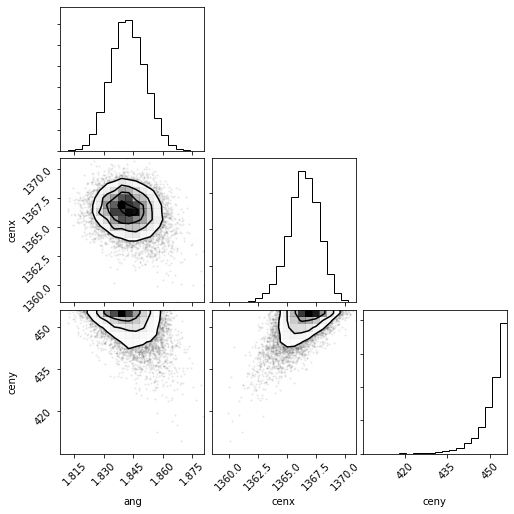

In [280]:
ss.plot_corner(samp)

In [315]:
flat_samples = samp.get_chain(discard=500, thin=15, flat=True)
ang = np.percentile(flat_samples[:, 0], 50)
xanch = np.percentile(flat_samples[:, 1], 50)
yanch = np.percentile(flat_samples[:, 2], 50)

xtest2, ytest2 = tm.rot_om2det(0, xanch, yanch, xom2, yom2, bound=True, order=2)

Order 2 (1.8420241914886666, 1366.4542081619645, 452.66587769561215)

In [308]:
samp = tm.do_emcee(xom1, yom1, xc, yc)

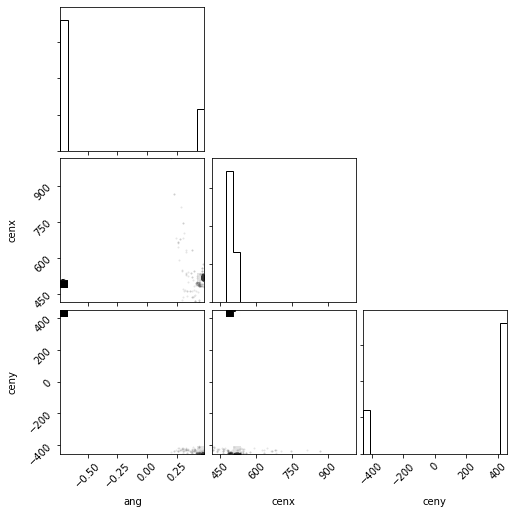

In [309]:
ss.plot_corner(samp)

In [310]:
flat_samples = samp.get_chain(discard=500, thin=15, flat=True)
ang = np.percentile(flat_samples[:, 0], 50)
xanch = np.percentile(flat_samples[:, 1], 50)
yanch = np.percentile(flat_samples[:, 2], 50)

xtest, ytest = tm.rot_om2det(0, xanch, yanch, xom1, yom1, bound=True)

Order 1
(1.489436258305047, 1513.7318466845256, 455.57624110013376)

### Test rotation with cv3 rotation set

In [353]:
data = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Gaussian_model/LoicsWork/SOSS_CV3_rotation_set/final_256x2048_sub-0.8__12.fits')[0].data
data = np.transpose(data[::-1,:])

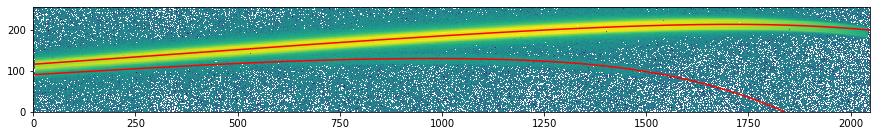

In [356]:
plt.figure(figsize=(15, 3))
plt.imshow(np.log10(data), origin='lower')
plt.plot(xc, yc, c='red')
plt.plot(xc2, yc2, c='red')

In [355]:
xc2, yc2, xc, yc = tm.get_o2_data_centroids(data, return_o1=True)

In [357]:
data = fits.open('/Users/michaelradica/Documents/School/Ph.D./Research/SOSS/Extraction/Gaussian_model/LoicsWork/SOSS_CV3_rotation_set/final_256x2048_sub2.1__10.fits')[0].data
data = np.transpose(data[::-1,:])

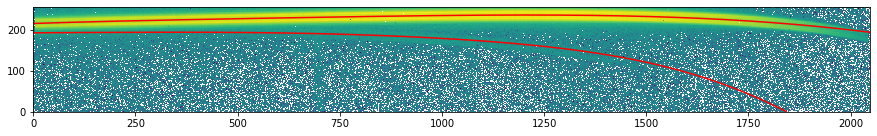

In [360]:
plt.figure(figsize=(15, 3))
plt.imshow(np.log10(data), origin='lower')
plt.plot(xc, yc, c='red')
plt.plot(xc2, yc2, c='red')

In [359]:
xc2, yc2, xc, yc = tm.get_o2_data_centroids(data, return_o1=True)

### Original reference files are wonky - order 2 trace has different curvature than optics model

In [149]:
#xmod2 = np.arange(2048)
#ymod2 = np.polyval(p2, xmod2)
samp = ss.do_emcee(xom2, yom2, xc2, yc2)

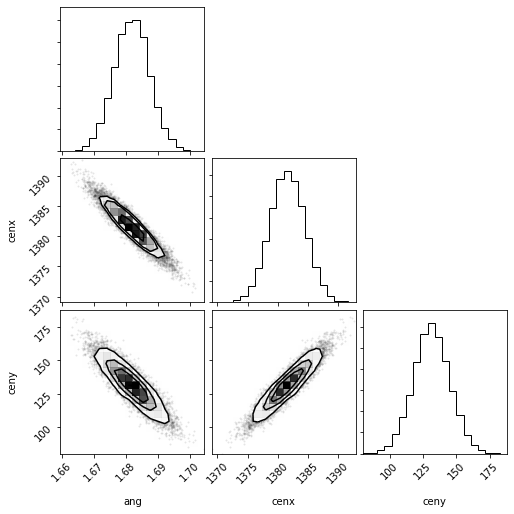

In [150]:
ss.plot_corner(samp)

In [151]:
flat_samples = samp.get_chain(discard=500, thin=15, flat=True)
ang = np.percentile(flat_samples[:, 0], 50)
xanch = np.percentile(flat_samples[:, 1], 50)
yanch = np.percentile(flat_samples[:, 2], 50)

#xmr, ymr = ss.rot_om2det(ang, xanch, yanch, xom1, yom1, bound=True)
xmr2, ymr2 = ss.rot_om2det(ang, xanch, yanch, xom2, yom2, bound=True)

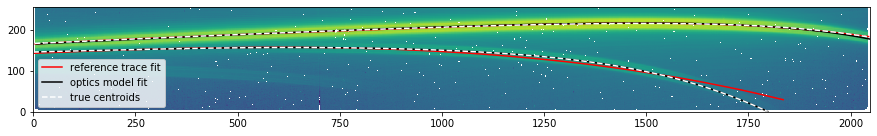

In [161]:
plt.figure(figsize=(15, 3))
plt.imshow(np.log10(stack), origin='lower')
plt.plot(xr, yr, c='red', label='reference trace fit')
plt.plot(xmr, ymr, c='black', label='optics model fit')
plt.plot(xc, yc, c='white', ls='--', label='true centroids')
plt.plot(xr2, yr2, c='red')
plt.plot(xmr2, ymr2, c='black')
plt.plot(xc2, yc2, c='white', ls='--')
plt.legend()
#plt.savefig('profile.png')

### Remake reference trace files

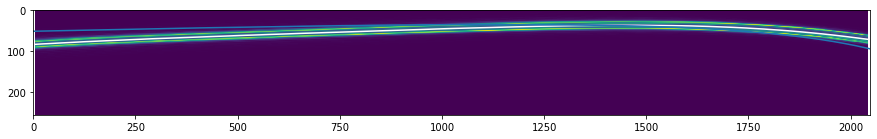

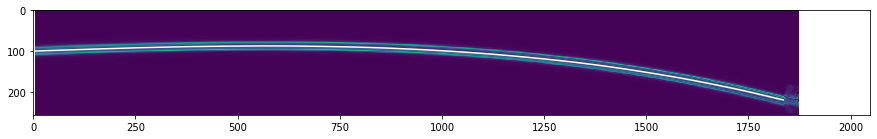

In [389]:
ref_O1 = fits.open('../Ref_files/trace_profile_m1.fits')[0].data 
x, y = ss.get_o1_data_centroids(ref_O1[0,0,:,:], atthesex=np.arange(2048))
plt.figure(figsize=(15, 3))
plt.imshow(ref_O1[0,0,:,:]/np.sum(ref_O1[0,0,:,:], axis=0))
plt.plot(x, y, c='white')
#plt.plot(np.arange(2048), np.polyval(p1, np.arange(2048)), c='red')
plt.plot(xom1, 256-yom1)
plt.show()

ref_O2 = fits.open('../Ref_files/trace_profile_m2.fits')[0].data   
x2, y2 = tm.get_o1_data_centroids(ref_O2[0,0,:,:], atthesex=np.arange(1840))
plt.figure(figsize=(15, 3))
plt.imshow(ref_O2[0,0,:,:]/np.sum(ref_O2[0,0,:,:], axis=0))
plt.plot(x2,y2, c='white')
#plt.plot(np.arange(2048), np.polyval(p2, np.arange(2048)), c='red')
#plt.xlim(0,1832)
#plt.ylim(0,256)

In [163]:
# Optics model centroids
xom1, yom1, tps = tm.get_om_centroids(atthesex=np.arange(2048), order=1)
xom2, yom2, tps = tm.get_om_centroids(atthesex=np.arange(2048), order=2)

In [371]:
newframe = np.zeros((256, 2048))

In [410]:
x, y, xom1[:5]

(array([   4,    5,    6, ..., 2041, 2042, 2043]),
 array([83.09466386, 83.08455888, 83.03424135, ..., 70.65921379,
        70.86683805, 70.95738299]),
 array([0.05670457, 1.0558985 , 2.05508347, 3.05425974, 4.05342754]))

In [413]:
for i, col in enumerate(x):
    ycen = int(round(y[i]*10, 0))
    ax_over = np.linspace(0, 256, 2560) #10x oversampled
    overslice = np.interp(ax_over, np.arange(256), ref_O1[0,0,:,col])    
    tslice = overslice[(ycen-340):(ycen+350)]
    
    axis = np.linspace(-34, 34, 690) + (256-yom1[col]) - 1
    inds = np.where((axis < 256) & (axis >= 0))[0]
    newslice = np.interp(np.arange(256), axis[inds], tslice[inds])
    
    newframe[:, col] = newslice
    

(0, 2048)

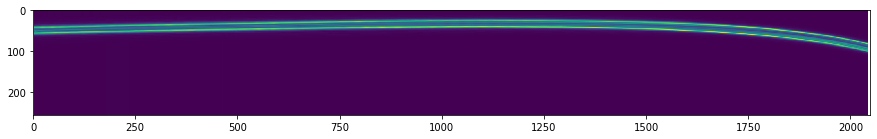

In [414]:
plt.figure(figsize=(15, 3))
plt.imshow(newframe/np.sum(newframe, axis=0))
#plt.plot(xom2, yom2, c='red')
plt.xlim(0,2048)

In [376]:
hdu = fits.PrimaryHDU()
hdu.data = newframe
hdu.writeto('trace_profile_m2.fits', overwrite=True)

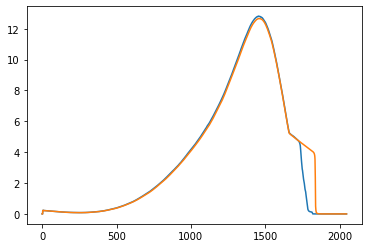

In [285]:
plt.plot(np.sum(newframe, axis=0))
plt.plot(np.sum(ref_O2[0,0,::-1,:], axis=0))

In [282]:
np.sum(ref_O2[0,0,::-1,:], axis=0)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)